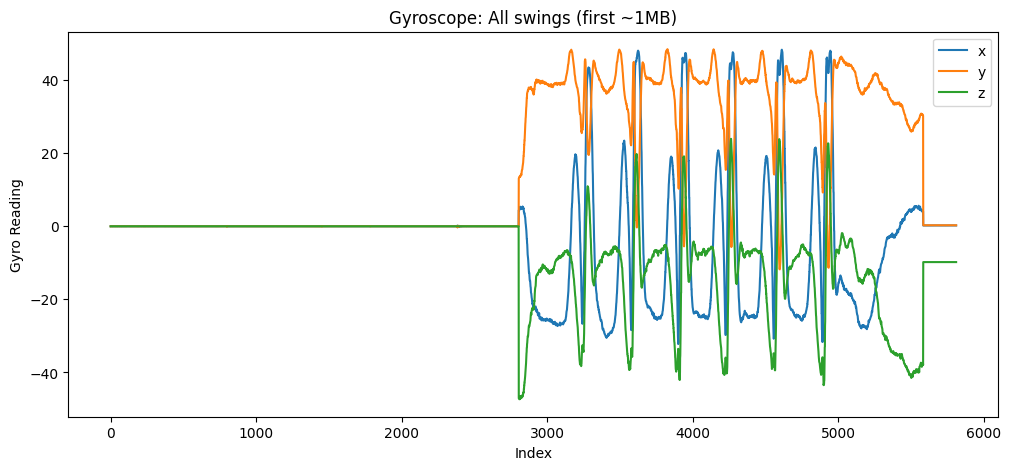

(          y         x  seconds_elapsed         z     sensor  \
 0 -0.018746 -0.003512         0.064767 -0.003250  Gyroscope   
 1 -0.007725 -0.002234         0.074745  0.000731  Gyroscope   
 2  0.005743  0.001533         0.084724 -0.002248  Gyroscope   
 3  0.016039  0.002187         0.094703  0.001668  Gyroscope   
 4  0.026000  0.004374         0.104682  0.003591  Gyroscope   
 
                   time  
 0  1761072567095766800  
 1  1761072567105745000  
 2  1761072567115723800  
 3  1761072567125703000  
 4  1761072567135681500  ,
                  y            x  seconds_elapsed            z
 count  5812.000000  5812.000000      5812.000000  5812.000000
 mean     16.920350    -2.783390        13.627535    -7.643089
 std      19.188178    15.438790         8.301661    12.426012
 min     -11.799225   -32.235229         0.064767   -47.333313
 25%       0.000028   -12.329185         6.291265   -10.713470
 50%       0.272111    -0.000430        13.564855    -0.002634
 75%      38.933

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load a manageable chunk of the huge JSON sensor file
json_filepath = '/Users/ashleychen/Developer/git/tennis-swing-class/backhand_x_3-2025-10-21_18-49-27.json'
with open(json_filepath, 'r') as f:
    line = f.readline()
    partial_data = line[:1000000]  # First ~1MB
    last_record_end = partial_data.rfind('},')
    if last_record_end > 0:
        data_json = '[' + partial_data[1:last_record_end+1] + ']'
    else:
        data_json = partial_data
    data = json.loads(data_json)

df = pd.DataFrame(data)
# Data cleaning
for col in ['x','y','z','seconds_elapsed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna().copy()

# Quick plot to visualize full recording
df[['x','y','z']].plot(figsize=(12, 5), title='Gyroscope: All swings (first ~1MB)')
plt.xlabel('Index')
plt.ylabel('Gyro Reading')
plt.show()

# Show snippet and stats
df.head(), df.describe()


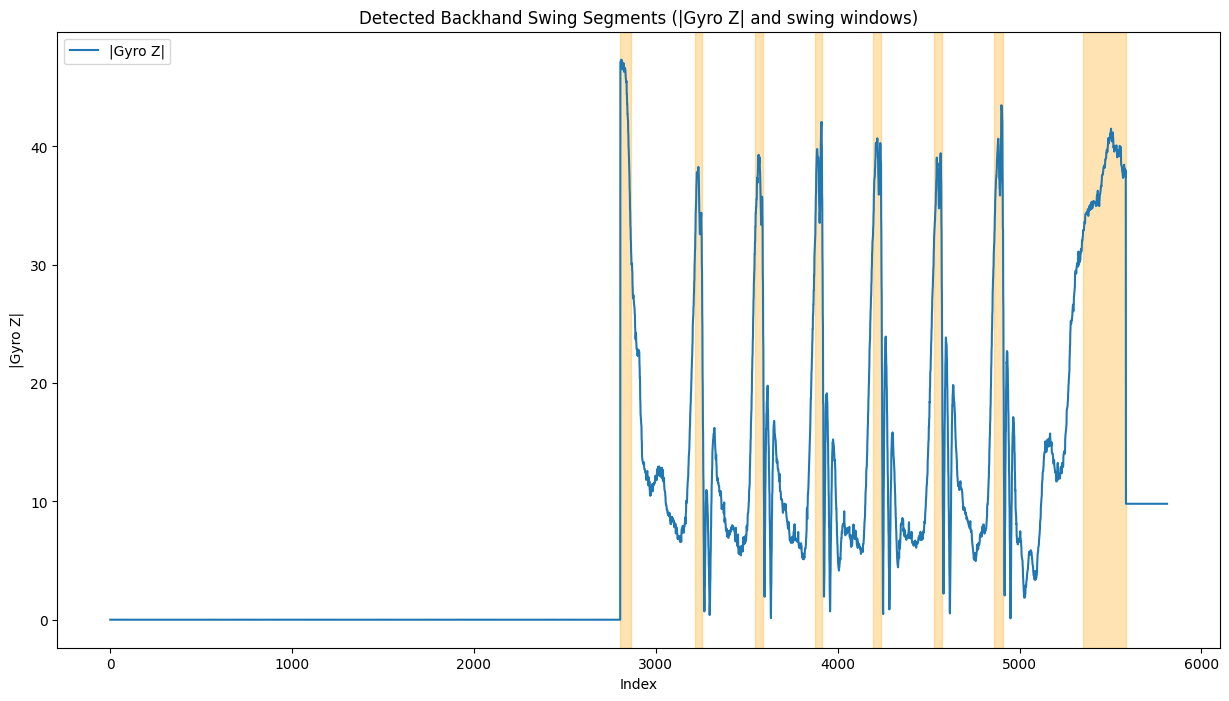

Detected swings: 8
Swing 1: Index 2805 to 2861
Swing 2: Index 3217 to 3252
Swing 3: Index 3547 to 3587
Swing 4: Index 3876 to 3915
Swing 5: Index 4193 to 4240


In [3]:
# Partition the swings using the gyroscope data (simple swing segmentation)
# Here, we'll assume large peaks in |Gyro Z| indicate turns/swings
threshold = df['z'].abs().mean() + 2*df['z'].abs().std()

# Basic peak detection (room for improvement)
swing_indices = df.index[df['z'].abs() > threshold].tolist()

# Group consecutive indices as swing events
from itertools import groupby
from operator import itemgetter

swings = []
for k, g in groupby(enumerate(swing_indices), lambda ix : ix[0] - ix[1]):
    group = list(map(itemgetter(1), g))
    swings.append((group[0], group[-1]))

# Visualize detected swing segments
plt.figure(figsize=(15, 8))
plt.plot(df['z'].abs(), label='|Gyro Z|')
for start, end in swings:
    plt.axvspan(start, end, color='orange', alpha=0.3)
plt.title('Detected Backhand Swing Segments (|Gyro Z| and swing windows)')
plt.xlabel('Index')
plt.ylabel('|Gyro Z|')
plt.legend(['|Gyro Z|'])
plt.show()

print(f"Detected swings: {len(swings)}")
for i, (start, end) in enumerate(swings[:5]):
    print(f"Swing {i+1}: Index {start} to {end}")
